<a href="https://colab.research.google.com/github/umbertoselva/House_Price_EDA_Regression/blob/main/House_Price_EDA_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis and Regression on a House Price Dataset

## Table of Contents

1. [Introduction](#s01)

2. [Environment Setup](#s02)

- a) [Installing and Importing Libraries](#s02a)

- b) [Loading the Database](#s02b)

3. [Dataset Overview](#s03)

4. [Exploratory Data Analysis](#s04)

- a) [Analyze target variable](#s04a)

- b) [Exploratory Data Analysis of all Variables](#s04b)

  - [OverallQuality](#s04b01)
  - [LivingAreaSF](#s04b02)
  - [BasementSF](#s04b03)
  - [YearBuilt](#s04b04)
  - [Bedrooms](#s04b05)
  - [Bathrooms](#s04b06)
  - [AC](#s04b07)
  - [StreetSizeF](#s04b08)
  - [GarageCars](#s04b09)
  - [GarageAreaSF](#s04b10)

- c) [Predictive Features](#s04c)

- d) [Handling Outliers](#s04d)

5. [Splitting into Train and Test Set](#s05)

6. [Data Preprocessing](#s06)

- a) [Encoding Non-numerical Categorical Data](#s06a)

- b) [Handling Missing Data](#s06b)

- c) [Resampling](#s06c)

- d) [Scaling](#s06d)

- e) [Identifying Reduntant Features (Multicollinearity)](#s06e)

- f) [Feature Selection](#s06f)

7. [Model Design](#s07)

- a) [Create Input Matrices](#s07a)

- b) [Baseline Model: Linear Regression](#s07b)

- c) [XGBoost](#s07c)

- d) [Neural Network](#s07d)

8. [Explainability](#s08)

<a name="s01"></a>
## 1) Introduction

This notebook contains a step-by-step example of how to apply Data Science to a Regression task. The goal will be to create a Machine Learning model to predict the price of residential houses on the basis of a large dataset containing a variety of explanatory variables (from the living area squared meters to the number of bedrooms). I shall conduct exploratory data analysis, data preprocessing, feature selection, model design, training, evaluation and model explainability.

I have prepared a custom dataset on the basis of the following Kaggle dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data. The original dataset contains 81 columns. I reduced it to 12, including the target and ID columns, so eventually to 10 features.

I have uploaded the following files to Google colab:
- the CSV file containing the dataset
- the ds_utils.py file containing a few custom functions for data science

In [1]:
!ls

ds_utils.py  house_price_database.csv  sample_data


<a name="s02"></a>
## 2) Environment Setup

<a name="s02a"></a>
### a) Installating and Importing Libraries

In [2]:
%%capture
pip install lime

In [3]:
%%capture
pip install shap==0.35.0

In [4]:
# for data
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# for statistic testing
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, linear_model, \
decomposition, metrics

# for deep learning
from tensorflow.keras import models, layers, backend

# for explainability
from lime import lime_tabular
import shap

# custom data science functions
from ds_utils import df_overview, univariate_plots, bivariate_plots, \
correlation_tests, encode_cat, plot_keras_loss, evaluate_regr_model

import warnings
warnings.filterwarnings("ignore")

<a name="s02b"></a>
### b) Loading the Database

In [5]:
df = pd.read_csv("/content/house_price_database.csv")
df

,Id,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,SalePrice
0,1,7,1710,856,2003,3,2,Y,65.0,2,548,208500
1,2,6,1262,1262,1976,3,2,Y,80.0,2,460,181500
2,3,7,1786,920,2001,3,2,Y,68.0,2,608,223500
3,4,7,1717,756,1915,3,1,Y,60.0,3,642,140000
4,5,8,2198,1145,2000,4,2,Y,84.0,3,836,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,6,1647,953,1999,3,2,Y,62.0,2,460,175000
1456,1457,6,2073,1542,1978,3,2,Y,85.0,2,500,210000
1457,1458,7,2340,1152,1941,4,2,Y,66.0,1,252,266500
1458,1459,5,1078,1078,1950,2,1,Y,68.0,1,240,142125


<a name="s03"></a>
## 3) Dataset Overview

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              1460 non-null   int64  
 1   OverallQuality  1460 non-null   int64  
 2   LivingAreaSF    1460 non-null   int64  
 3   BasementSF      1460 non-null   int64  
 4   YearBuilt       1460 non-null   int64  
 5   Bedrooms        1460 non-null   int64  
 6   Bathrooms       1460 non-null   int64  
 7   AC              1460 non-null   object 
 8   StreetSizeF     1201 non-null   float64
 9   GarageCars      1460 non-null   int64  
 10  GarageAreaSF    1460 non-null   int64  
 11  SalePrice       1460 non-null   int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 137.0+ KB


Shape: (1460, 12)
-----------------
Id --> Type:num | NaN values: 0(0%) | Min-Max: (1)-(1460) | Possible Primary Key
OverallQuality --> Type:cat | NaN values: 0(0%) | Categories: 10
LivingAreaSF --> Type:num | NaN values: 0(0%) | Min-Max: (334)-(5642)
BasementSF --> Type:num | NaN values: 0(0%) | Min-Max: (0)-(6110)
YearBuilt --> Type:num | NaN values: 0(0%) | Min-Max: (1872)-(2010)
Bedrooms --> Type:cat | NaN values: 0(0%) | Categories: 8
Bathrooms --> Type:cat | NaN values: 0(0%) | Categories: 4
AC --> Type:cat | NaN values: 0(0%) | Categories: 2
StreetSizeF --> Type:num | NaN values: 259(17%) | Min-Max: (21)-(313)
GarageCars --> Type:cat | NaN values: 0(0%) | Categories: 5
GarageAreaSF --> Type:num | NaN values: 0(0%) | Min-Max: (0)-(1418)
SalePrice --> Type:num | NaN values: 0(0%) | Min-Max: (34900)-(755000)


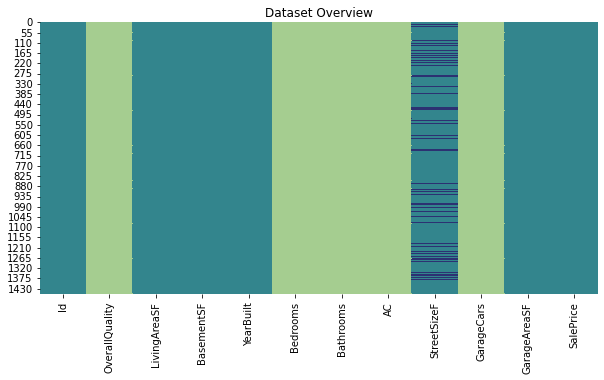

 Light Green = Categorical   Dark Green = Numerical   Blue = NaN 


In [7]:
# for this custom function see ds_utils.py

df_overview(df)

Variables:

- **OverallQuality**: [CAT numerical] Overally quality (Values from 1 to 10)
- **LivingAreaSF**: [NUM continuous] Above grade (ground) living area in square feet
- **BasementSF**: [NUM continuous] Total square feet of basement area
- **YearBuilt**: [NUM continuous] Original construction date
- **Bedrooms**: [CAT numerical] Num of bedrooms 
- **Bathrooms**: [CAT numerical] Num of bathrooms
- **AC**: [CAT non-numerical] Air conditioning (Values: Y / N)
- **StreetSizeF** [NUM continuous] Linear feet of street connected to property
- **GarageCars** [CAT numerical] Size of garage in car capacity
- **GarageAreaSF** [NUM continuous] Size of garage in square feet
- **SalePrice**: [NUM continuous] prince in dollars (this is our target variable)

In [8]:
df.describe()

,Id,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,StreetSizeF,GarageCars,GarageAreaSF,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,6.099315,1515.463699,1057.429452,1971.267808,2.866438,1.565068,70.049958,1.767123,472.980137,180921.195890
std,421.610009,1.382997,525.480383,438.705324,30.202904,0.815778,0.550916,24.284752,0.747315,213.804841,79442.502883
min,1.000000,1.000000,334.000000,0.000000,1872.000000,0.000000,0.000000,21.000000,0.000000,0.000000,34900.000000
25%,365.750000,5.000000,1129.500000,795.750000,1954.000000,2.000000,1.000000,59.000000,1.000000,334.500000,129975.000000
50%,730.500000,6.000000,1464.000000,991.500000,1973.000000,3.000000,2.000000,69.000000,2.000000,480.000000,163000.000000
75%,1095.250000,7.000000,1776.750000,1298.250000,2000.000000,3.000000,2.000000,80.000000,2.000000,576.000000,214000.000000
max,1460.000000,10.000000,5642.000000,6110.000000,2010.000000,8.000000,3.000000,313.000000,4.000000,1418.000000,755000.000000


Let's verify that the number of unique Ids is equal to the number of rows

In [9]:
df['Id'].nunique() == len(df)

True

Let's set the 'Id' column as index column

In [10]:
df = df.set_index("Id")
df.head()

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,SalePrice
Id,,,,,,,,,,,
1,7,1710,856,2003,3,2,Y,65.0,2,548,208500
2,6,1262,1262,1976,3,2,Y,80.0,2,460,181500
3,7,1786,920,2001,3,2,Y,68.0,2,608,223500
4,7,1717,756,1915,3,1,Y,60.0,3,642,140000
5,8,2198,1145,2000,4,2,Y,84.0,3,836,250000


<a name="s04"></a>
## 4) Exploratory Data Analysis

Our goal in this section is mainly to identify which features are predictive of our target variables.

In general we also aim to gather insights about the single variables, identify issues, outliers, missing data, correlation, etc. which we will then tackle in the data preprocessing step.

a) [Analyze the Target Variable](#s04a)

b) [Exploratory Data Analysis of All Variables](#s04b)

- [OverallQuality](#s04b01)
- [LivingAreaSF](#s04b02)
- [BasementSF](#s04b03)
- [YearBuilt](#s04b04)
- [Bedrooms](#s04b05)
- [Bathrooms](#s04b06)
- [AC](#s04b07)
- [StreetSizeF](#s04b08)
- [GarageCars](#s04b09)
- [GarageAreaSF](#s04b10)

c) [Predictive Features](#s04c)

d) [Handling Outliers](#s04d)

<a name="s04a"></a>
### a) Analyze the Target Variable

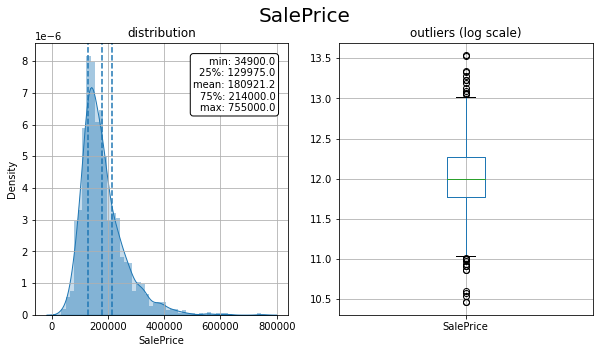

In [11]:
# for this custom function see ds_utils.py

univariate_plots(df, 'SalePrice', box_logscale=True, figsize=(10,5))

Let us visualize each variable's correlation to the target

In [12]:
df_corr = df.corr(method='pearson').loc[['SalePrice']] 
# note the [[ ]]: we want to return a DataFrame, not a Series
# df_corr = df_corr.abs() # in case of negative values
df_corr

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,StreetSizeF,GarageCars,GarageAreaSF,SalePrice
SalePrice,0.790982,0.708624,0.613581,0.522897,0.168213,0.560664,0.351799,0.640409,0.623431,1.0


Text(0.5, 1.0, 'Pearson correlation')

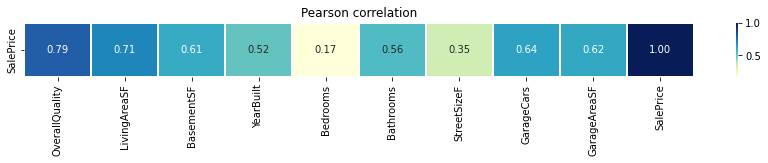

In [13]:
fig, ax = plt.subplots(figsize=(15, 1))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax, cbar=True, linewidths=0.5)
plt.title("Pearson correlation")

<a name="s04b"></a>
### b) Exploratory Data Analysis of All Variables

Let us set up a `features` list to collect the features that we find to be predictive of our target during our exploratory analysis

In [14]:
features = []

<a name="s04b01"></a>
**OverallQuality**

[CAT numerical] 

Overally quality (Values from 1 to 10)

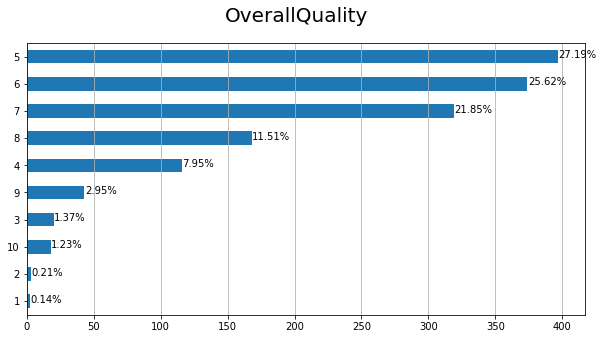

In [15]:
univariate_plots(df, 'OverallQuality', figsize=(10,5))

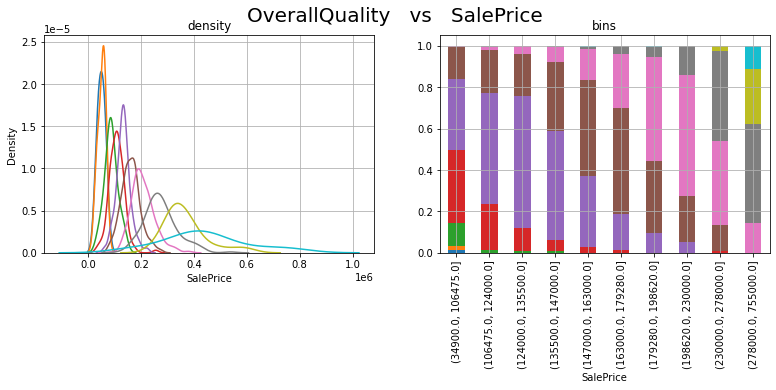

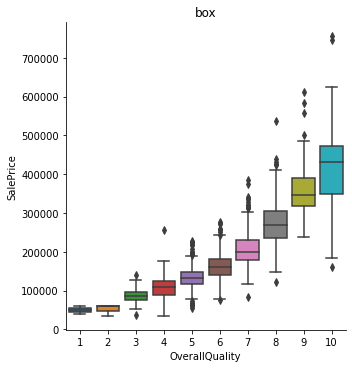

In [16]:
# for this custom function see ds_utils.py

bivariate_plots(df, x="OverallQuality", y="SalePrice", figsize=(13,4))

In [17]:
# for this custom function see ds_utils.py

correlation_tests(df, 'OverallQuality', 'SalePrice')

Anova LM test results: Significant (p-value < 0.05)
F-statistic: 2436.7705909063725
P-value: 2.185675268e-313 or 0.0
The variables are correlated


'OverallQuality' is predictive of our target.

As the quality increases, so does the price.

In [18]:
features.append('OverallQuality')

From the box plot we can also observe that there are some outliers with 'OverallQuality' value 10, but with an exceptionally low 'SalePrice'. Let us keep these in mind as we continue our analysis.

In [19]:
df[(df['OverallQuality'] == 10) & (df['SalePrice'] < 200000)]

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,SalePrice
Id,,,,,,,,,,,
524,10,4676,3138,2007,3,3,Y,130.0,3,884,184750
1299,10,5642,6110,2008,3,2,Y,313.0,2,1418,160000


<a name="s04b02"></a>
**LivingAreaSF**

[NUM continuous] 

Above grade (ground) living area in square feet

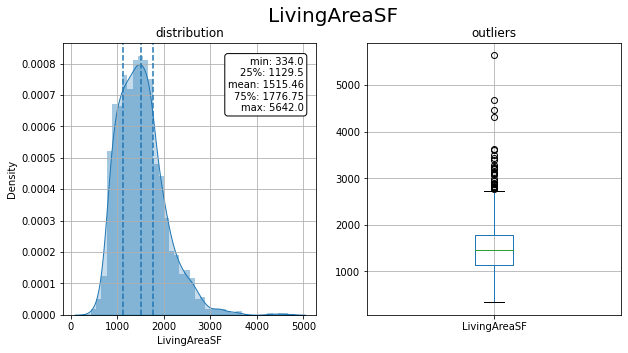

In [20]:
univariate_plots(df, 'LivingAreaSF', figsize=(10,5))

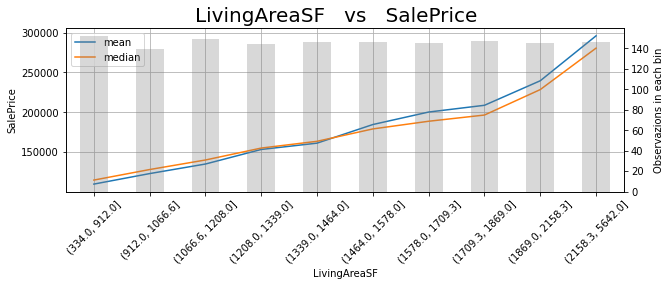

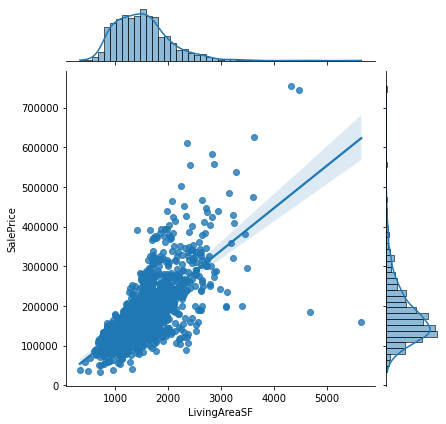

In [21]:
bivariate_plots(df, x="LivingAreaSF", y="SalePrice", figsize=(10, 3))

In [22]:
correlation_tests(df, 'LivingAreaSF', 'SalePrice', summary=False)

Pearson R test result: Significant (p-value < 0.05)
P-value: 4.518033646779431e-223 or 0.0
Pearson coefficient: 0.709
Strong positive correlation

OLS Regression test results: Significant (p-value < 0.05)
P-value: 4.518033646776791e-223 or 0.0
R-squared: 0.502
Regression coefficient: 107.13
Pearson coefficient: 0.709
Strong positive correlation


'LivingAreaSF' is predictive of the price.

The larger the living area, the higher the price.

In [23]:
features.append('LivingAreaSF')

Again from the bottom right of scatter plot we can spot the same outliers:

In [24]:
df[(df['LivingAreaSF'] > 4500) & (df['SalePrice'] < 200000)]

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,SalePrice
Id,,,,,,,,,,,
524,10,4676,3138,2007,3,3,Y,130.0,3,884,184750
1299,10,5642,6110,2008,3,2,Y,313.0,2,1418,160000


<a name="s04b03"></a>
**BasementSF**

[NUM continuous] 

Total square feet of basement area

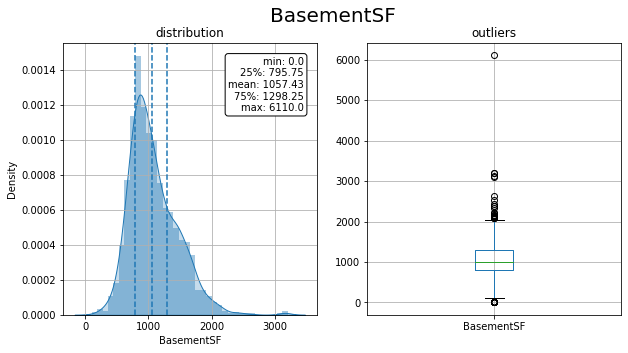

In [25]:
univariate_plots(df, 'BasementSF', figsize=(10,5))

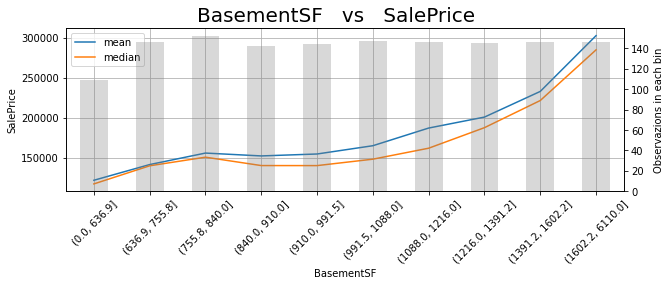

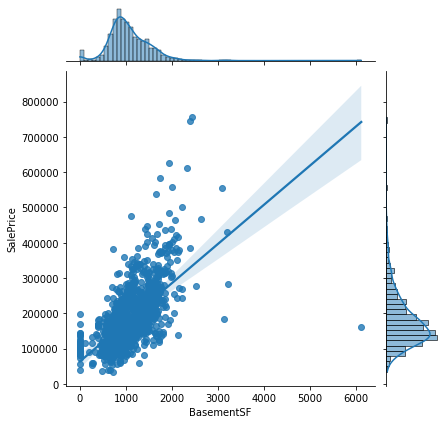

In [26]:
bivariate_plots(df, x="BasementSF", y="SalePrice", figsize=(10, 3))

In [27]:
correlation_tests(df, 'BasementSF', 'SalePrice')

Pearson R test result: Significant (p-value < 0.05)
P-value: 9.484229391507914e-152 or 0.0
Pearson coefficient: 0.614
Strong positive correlation

OLS Regression test results: Significant (p-value < 0.05)
P-value: 9.484229391499009e-152 or 0.0
R-squared: 0.376
Regression coefficient: 111.11
Pearson coefficient: 0.614
Strong positive correlation


Just like 'LivingAreaSF' so 'BasementSF' is predictive of the price.

The more basement square feet, the higher the price.

In [28]:
features.append('BasementSF')

Again we notice the outlier with Id 1299 (see the bottom right of the scatter plot). 

In [29]:
df[(df['BasementSF'] > 3500) & (df['SalePrice'] < 200000)]

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,SalePrice
Id,,,,,,,,,,,
1299,10,5642,6110,2008,3,2,Y,313.0,2,1418,160000


<a name="s04b04"></a>
**YearBuilt**

[NUM continuous] 

Original construction date

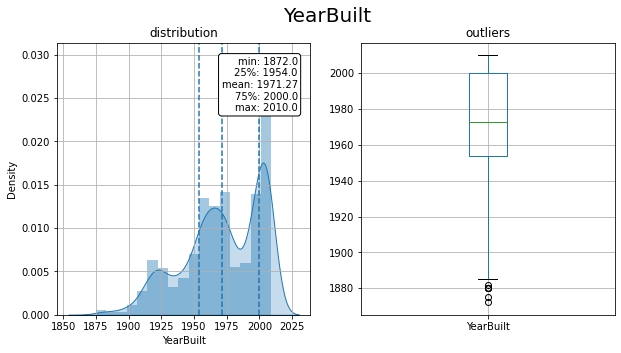

In [30]:
univariate_plots(df, 'YearBuilt', figsize=(10,5))

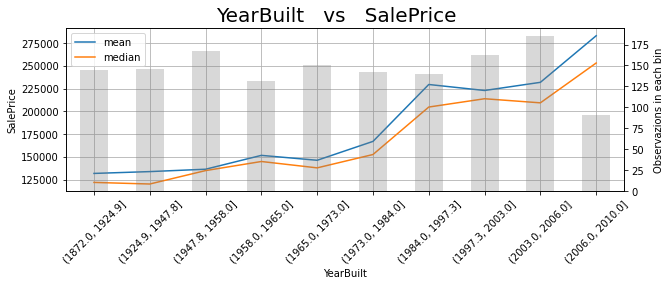

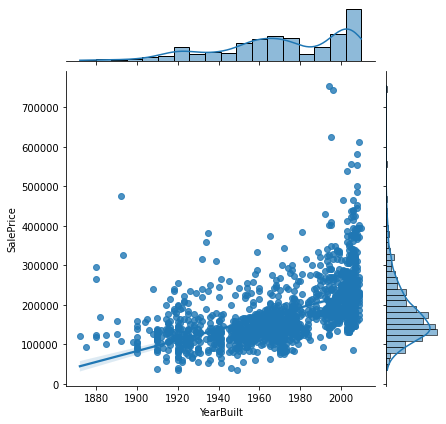

In [31]:
bivariate_plots(df, x="YearBuilt", y="SalePrice", figsize=(10, 3))

In [32]:
correlation_tests(df, 'YearBuilt', 'SalePrice')

Pearson R test result: Significant (p-value < 0.05)
P-value: 2.9902290990158995e-103 or 0.0
Pearson coefficient: 0.523
Strong positive correlation

OLS Regression test results: Significant (p-value < 0.05)
P-value: 2.990229099013344e-103 or 0.0
R-squared: 0.273
Regression coefficient: 1375.373
Pearson coefficient: 0.523
Strong positive correlation


'YearBuilt' is predictive of the price.

Houses built more recently are more highly priced.

In [33]:
features.append('YearBuilt')

<a name="s04b05"></a>
**Bedrooms**

[CAT numerical] 

Num of bedrooms

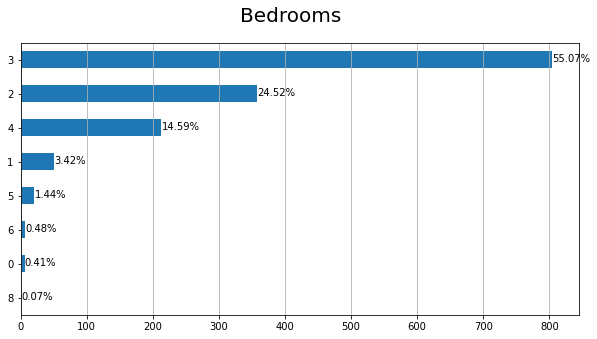

In [34]:
univariate_plots(df, 'Bedrooms', figsize=(10,5))

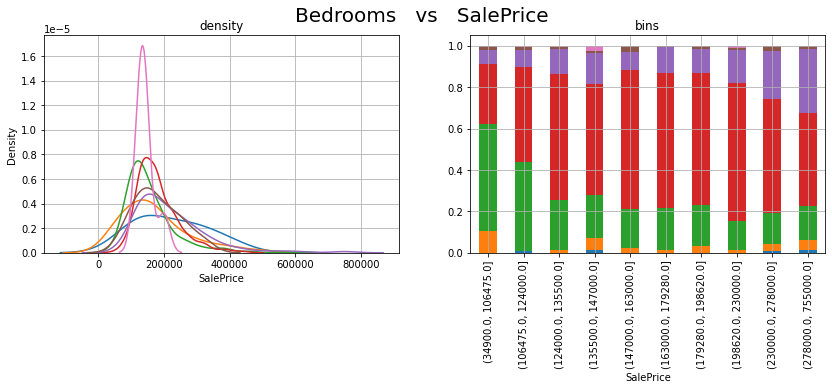

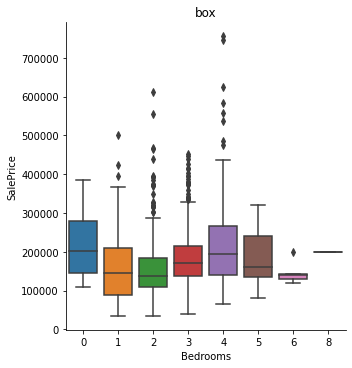

In [35]:
bivariate_plots(df, x="Bedrooms", y="SalePrice", figsize=(14, 4))

In [36]:
correlation_tests(df, 'Bedrooms', 'SalePrice')

Anova LM test results: Significant (p-value < 0.05)
F-statistic: 42.45641241256221
P-value: 9.927497326179764e-11 or 0.0
The variables are correlated


'Bedrooms' is predictive too with statistical significance.

The more bedrooms there are, the higher the house price.

In [37]:
features.append('Bedrooms')

<a name="s04b06"></a>
**Bathrooms**

[CAT numerical] 

Num of bathrooms 

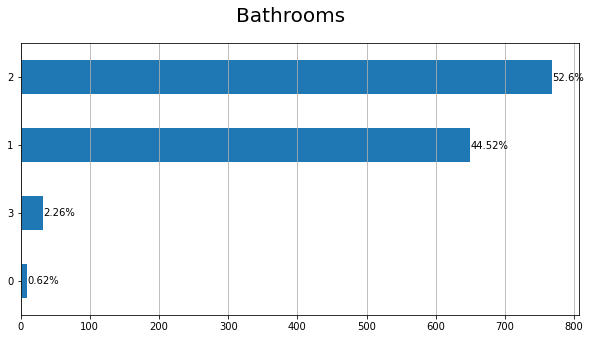

In [38]:
univariate_plots(df, 'Bathrooms', figsize=(10,5))

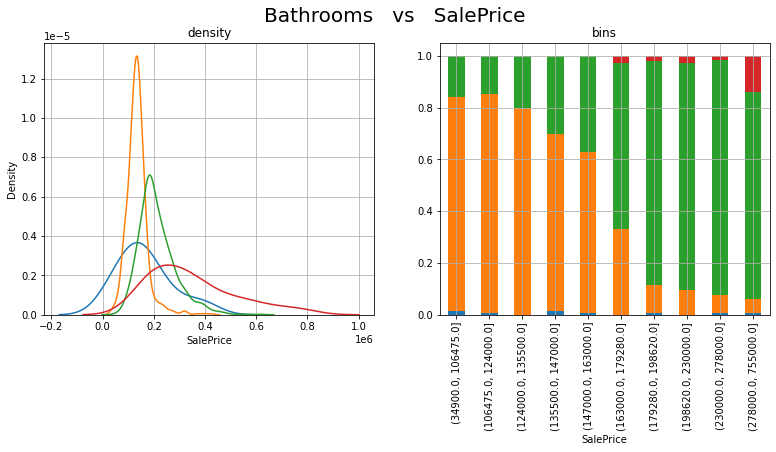

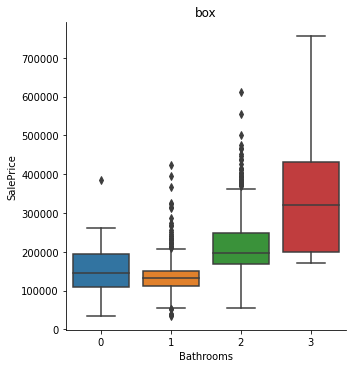

In [39]:
bivariate_plots(df, x="Bathrooms", y="SalePrice", figsize=(13, 5))

In [40]:
correlation_tests(df, 'Bathrooms', 'SalePrice')

Anova LM test results: Significant (p-value < 0.05)
F-statistic: 668.4302964873096
P-value: 1.236470066760021e-121 or 0.0
The variables are correlated


'Bathrooms' is predictive.

The more bathrooms there are, the higher the house price is.

In [41]:
features.append('Bathrooms')

<a name="s04b07"></a>
**AC**

[CAT non-numerical] 

Air conditioning (Values: Y / N)

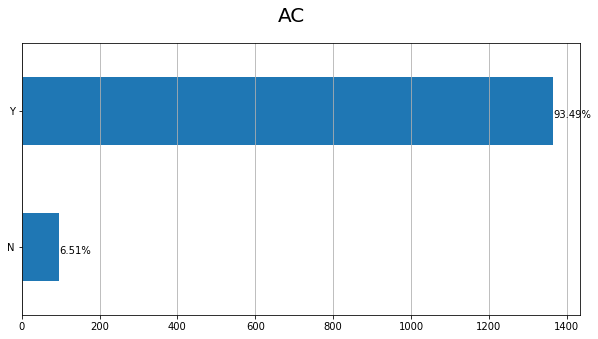

In [42]:
univariate_plots(df, 'AC', figsize=(10,5))

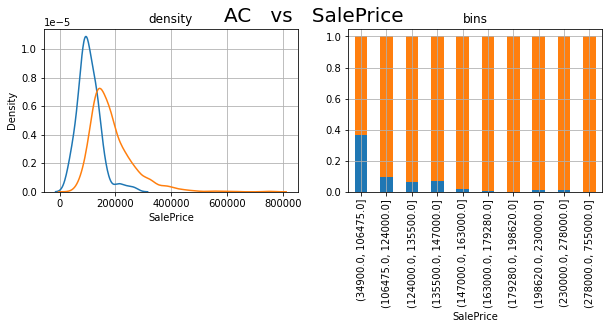

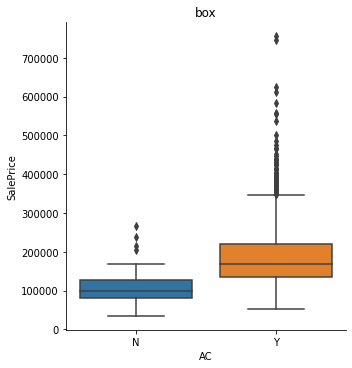

In [43]:
bivariate_plots(df, x="AC", y="SalePrice", figsize=(10, 3))

In [44]:
correlation_tests(df, 'AC', 'SalePrice')

Anova LM test results: Significant (p-value < 0.05)
F-statistic: 98.30534356615229
P-value: 1.8095061559271068e-22 or 0.0
The variables are correlated


'AC' is predictive.

Houses with central AC installed cost more.

In [45]:
features.append('AC')

<a name="s04b08"></a>
**StreetSizeF**

[NUM continuous] 

Linear feet of street connected to property

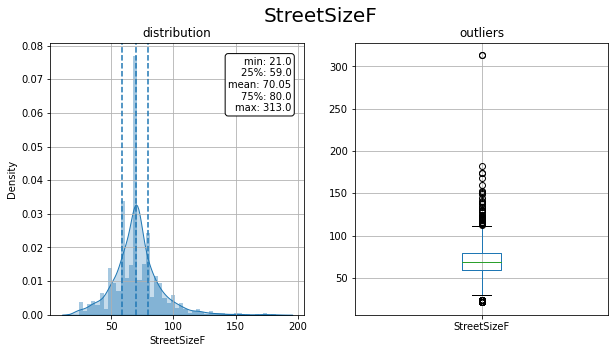

In [46]:
univariate_plots(df, 'StreetSizeF', figsize=(10,5))

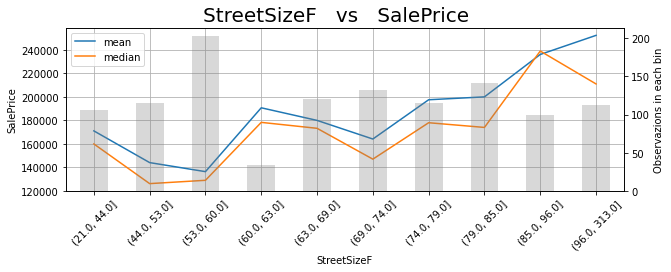

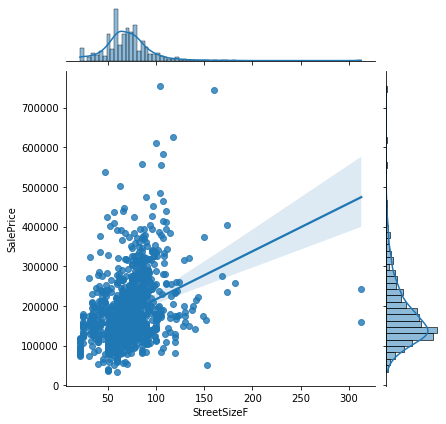

In [47]:
bivariate_plots(df, x="StreetSizeF", y="SalePrice", figsize=(10, 3))

In [48]:
correlation_tests(df, 'StreetSizeF', 'SalePrice')

Pearson R test result: Significant (p-value < 0.05)
P-value: 2.6024418123943414e-36 or 0.0
Pearson coefficient: 0.352
Slight positive correlation

OLS Regression test results: Significant (p-value < 0.05)
P-value: 2.6024418123910342e-36 or 0.0
R-squared: 0.124
Regression coefficient: 1208.016
Pearson coefficient: 0.352
Slight positive correlation


'StreetSizeF' is predictive, even though the correlation is less strong than other variabls.

The larger the size of the street connected to the property, the higher the house price.

Note that this column contains numerous missing values. We'll analyze that below.

In [49]:
features.append('StreetSizeF')

Again looking at the scatter plot we notice an outlier, again the one with id 1299: a property with very large SF surface, but a very low price.

In [50]:
df[(df['StreetSizeF'] > 200) & (df['SalePrice'] < 300000)]

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,SalePrice
Id,,,,,,,,,,,
935,7,2069,585,1960,4,2,Y,313.0,2,505,242000
1299,10,5642,6110,2008,3,2,Y,313.0,2,1418,160000


<a name="s04b09"></a>
**GarageCars**

[CAT numerical] 

Size of garage in car capacity

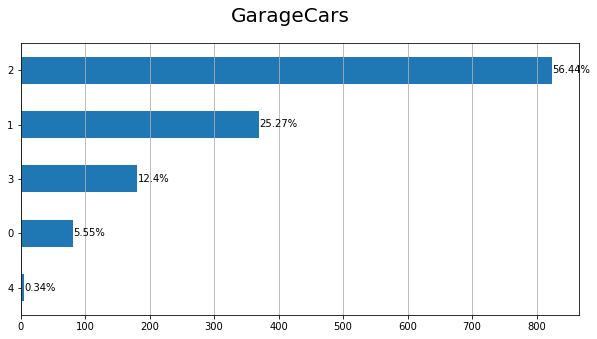

In [51]:
univariate_plots(df, 'GarageCars', figsize=(10,5))

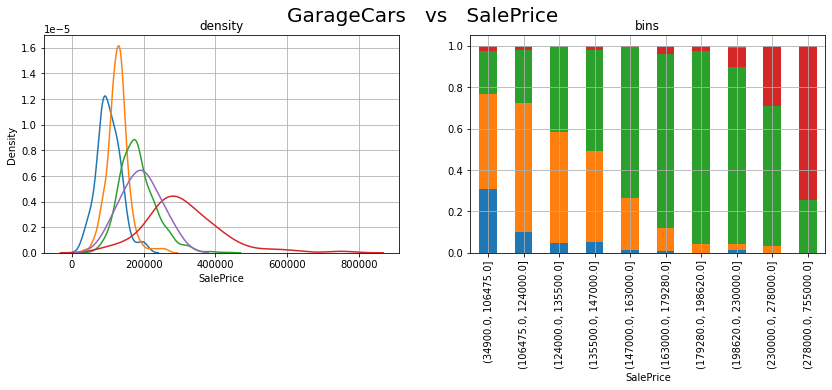

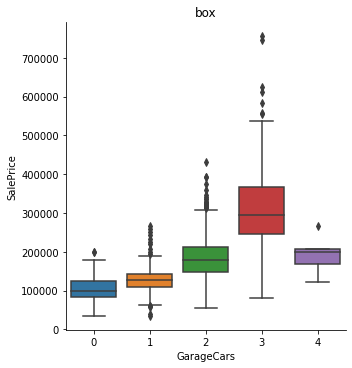

In [52]:
bivariate_plots(df, x="GarageCars", y="SalePrice", figsize=(14, 4))

In [53]:
correlation_tests(df, 'GarageCars', 'SalePrice')

Anova LM test results: Significant (p-value < 0.05)
F-statistic: 1013.7056661608054
P-value: 2.4986441671768163e-169 or 0.0
The variables are correlated


'GarageCars' is predictive.

The more cars can fit into the garage, the higher the house price.

In [54]:
features.append('GarageCars')

<a name="s04b10"></a>
**GarageAreaSF**

[NUM continuous] 

Size of garage in square feet

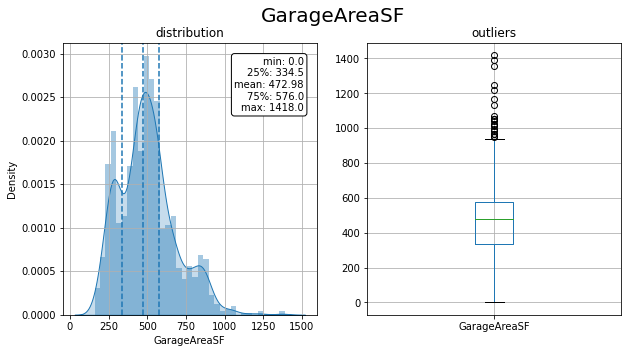

In [55]:
univariate_plots(df, 'GarageAreaSF', figsize=(10,5))

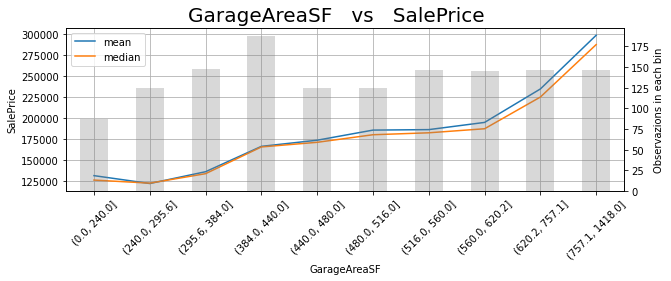

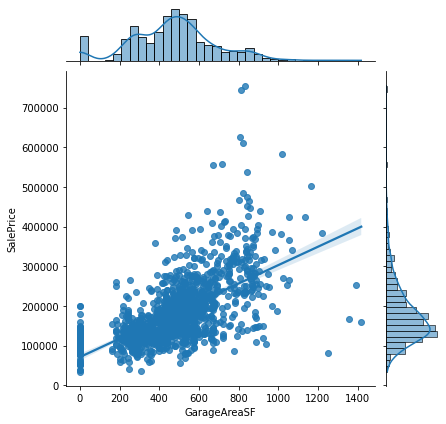

In [56]:
bivariate_plots(df, x="GarageAreaSF", y="SalePrice", figsize=(10, 3))

In [57]:
correlation_tests(df, 'GarageAreaSF', 'SalePrice')

Pearson R test result: Significant (p-value < 0.05)
P-value: 5.2650381679778054e-158 or 0.0
Pearson coefficient: 0.623
Strong positive correlation

OLS Regression test results: Significant (p-value < 0.05)
P-value: 5.265038167976654e-158 or 0.0
R-squared: 0.389
Regression coefficient: 231.646
Pearson coefficient: 0.623
Strong positive correlation


'GarageAreaSF' is predictive.

The larger the garage, the higher the house price.

In [58]:
features.append('GarageAreaSF')

Let us check the outliers:

In [59]:
df[(df['GarageAreaSF'] > 1200) & (df['SalePrice'] < 300000)]

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,SalePrice
Id,,,,,,,,,,,
582,8,2042,2042,2008,3,2,Y,98.0,3,1390,253293
1062,3,894,894,1935,2,1,Y,120.0,3,1248,81000
1191,4,1622,1249,1961,3,1,Y,NaN,4,1356,168000
1299,10,5642,6110,2008,3,2,Y,313.0,2,1418,160000


<a name="s04c"></a>
### c) Predictive Features

In [60]:
features

['OverallQuality',
 'LivingAreaSF',
 'BasementSF',
 'YearBuilt',
 'Bedrooms',
 'Bathrooms',
 'AC',
 'StreetSizeF',
 'GarageCars',
 'GarageAreaSF']

In [61]:
len(features)

10

In [62]:
# let us create a df with only the predictive features and the target

# df = pd.concat([pd.concat([df[features], df['SalePrice']], axis=1)
# df

After all, we've concluded that all of our database features are predictive to varying degrees, so we keep them all.

Let us rename our target as 'Y'

In [63]:
df = df.rename(columns={'SalePrice':'Y'})
df

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,Y
Id,,,,,,,,,,,
1,7,1710,856,2003,3,2,Y,65.0,2,548,208500
2,6,1262,1262,1976,3,2,Y,80.0,2,460,181500
3,7,1786,920,2001,3,2,Y,68.0,2,608,223500
4,7,1717,756,1915,3,1,Y,60.0,3,642,140000
5,8,2198,1145,2000,4,2,Y,84.0,3,836,250000
...,...,...,...,...,...,...,...,...,...,...,...
1456,6,1647,953,1999,3,2,Y,62.0,2,460,175000
1457,6,2073,1542,1978,3,2,Y,85.0,2,500,210000
1458,7,2340,1152,1941,4,2,Y,66.0,1,252,266500


<a name="s04d"></a>
### d) Handling Outliers

In order not to reduce an already small dataset, I shall not deal with outliers systematically with methods such as the percentile, inter-quartile or standard deviation based methods.

However, in the course of our exploratory data analysis, we have observed that there is at least one property, namely the one at 'Id' 1299, that appears to be an outlier with respects to multiple variables (at least conspicuously 'OverallQuality', 'LivingAreaSF', 'BasementSF', 'StreetSizeF', 'GarageAreaSF'). Basically this is a property with a very high total square feet surface and high overall quality score, that is, however, priced unusually low. We may want to investigate whether there was a mistake when collecting the data, or whether this is really the correct price - maybe the owner really wants to get rid of it!

At any rate this can be considered an exceptional case and we might consider removing it.

Let's review for instance the 'BasementSF' joint plot:



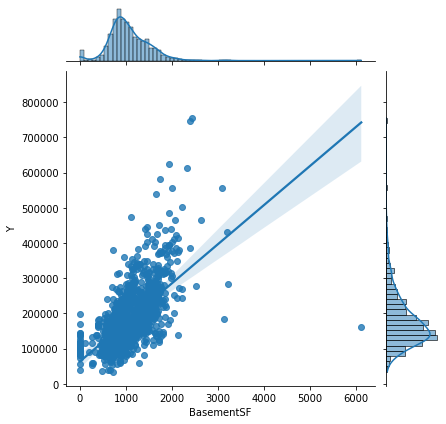

In [64]:
sns.jointplot('BasementSF','Y', df, kind='reg')

In [65]:
df[(df['BasementSF'] > 3500) & (df['Y'] < 200000)]

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,Y
Id,,,,,,,,,,,
1299,10,5642,6110,2008,3,2,Y,313.0,2,1418,160000


In [66]:
df.iloc[df.index == 1299]

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,Y
Id,,,,,,,,,,,
1299,10,5642,6110,2008,3,2,Y,313.0,2,1418,160000


In [67]:
df.iloc[1298] # count starts from 0

OverallQuality        10
LivingAreaSF        5642
BasementSF          6110
YearBuilt           2008
Bedrooms               3
Bathrooms              2
AC                     Y
StreetSizeF        313.0
GarageCars             2
GarageAreaSF        1418
Y                 160000
Name: 1299, dtype: object

It might be useful to remove this row from our database, otherwise it might negatively affect our predictive models.

In [68]:
df.shape

(1460, 11)

In [69]:
df.drop(1299, inplace=True)

In [70]:
df.shape

(1459, 11)

In [71]:
df.iloc[df.index == 1299]

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,Y
Id,,,,,,,,,,,


<a name="s05"></a>
## 5) Splitting into Train and Test Set

Splitting into train and test set should be performed at least before the Scaling step and possibly before the Handling Missing Data step. The general rule is not to use any information from the test set in our train set preprocessing.

We shall split first and then carry out all the preprocessing steps separately for the train and test sets.

In [72]:
# from sklearn import model_selection

# split 80% train 20% test
df_train, df_test = model_selection.train_test_split(df,
                                                     train_size=0.8,
                                                     shuffle=False)

In [73]:
# let's ensure that the train set's target mean
# is similar to the test set's target mean

print("Train set Y mean:", round(df_train['Y'].mean(), 2))
print("Test set Y mean:", round(df_test['Y'].mean(),2))

Train set Y mean: 180596.78
Test set Y mean: 182289.39


In [74]:
df_train.shape

(1167, 11)

In [75]:
df_test.shape

(292, 11)

In [76]:
df_train.shape[0] + df_test.shape[0]

1459

In [77]:
df_train.head()

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,AC,StreetSizeF,GarageCars,GarageAreaSF,Y
Id,,,,,,,,,,,
1,7,1710,856,2003,3,2,Y,65.0,2,548,208500
2,6,1262,1262,1976,3,2,Y,80.0,2,460,181500
3,7,1786,920,2001,3,2,Y,68.0,2,608,223500
4,7,1717,756,1915,3,1,Y,60.0,3,642,140000
5,8,2198,1145,2000,4,2,Y,84.0,3,836,250000


<a name="s06"></a>
## 6) Data Preprocessing

a) [Encoding Non-numerical Categorical Data](#s06a)

b) [Handling Missing Data](#s06b)

c) [Resampling](#s06c)

d) [Scaling](#s06d)

e) [Identifying Reduntant Features (Multicollinearity)](#s06e)

f) [Feature Selection](#s06f)

<a name="s06a"></a>
### a) Encoding Non-numerical Categorical Data

The variable 'AC' is categorical and non-numerical. It contains two values: 'Y' and 'N'.

Therefore we have to transform it into two one-hot encoded columns 'AC_Y' and 'AC_N' containing only '0' and '1' values.

We can also just keep 'AC_Y' (by means of the parameter `drop_first=True`).

And we can also drop the original 'AC' column.

In [78]:
# this custom function is also present in the ds_utils.py file

def encode_cat(df, cat, drop_orig=True, drop_first=True, dummy_na=False):

  # create dummy df
  df_dummy = pd.get_dummies(df[cat], prefix=cat, drop_first=drop_first, dummy_na=dummy_na)

  # concatenate features + dummy features + Y; make sure Y is at the end
  df = pd.concat([df.drop('Y', axis=1), df_dummy, df['Y']], axis=1) 

  # drop original feature
  if drop_orig == True:
    df = df.drop(cat, axis=1)

  return df

In [79]:
# encode train set
df_train = encode_cat(df_train, 'AC')
df_train

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,StreetSizeF,GarageCars,GarageAreaSF,AC_Y,Y
Id,,,,,,,,,,,
1,7,1710,856,2003,3,2,65.0,2,548,1,208500
2,6,1262,1262,1976,3,2,80.0,2,460,1,181500
3,7,1786,920,2001,3,2,68.0,2,608,1,223500
4,7,1717,756,1915,3,1,60.0,3,642,1,140000
5,8,2198,1145,2000,4,2,84.0,3,836,1,250000
...,...,...,...,...,...,...,...,...,...,...,...
1163,5,894,894,1968,3,1,109.0,2,450,1,129000
1164,4,1258,1198,1969,0,0,60.0,2,400,1,108959
1165,5,1432,1360,1978,2,1,NaN,2,588,1,194000


In [80]:
# encode test set
df_test = encode_cat(df_test, 'AC')
df_test

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,StreetSizeF,GarageCars,GarageAreaSF,AC_Y,Y
Id,,,,,,,,,,,
1168,6,1671,959,2000,3,2,58.0,2,472,1,173000
1169,6,2108,1127,1935,4,2,120.0,2,540,1,235000
1170,10,3627,1930,1995,4,3,118.0,3,807,1,625000
1171,6,1118,1096,1977,3,1,76.0,1,358,1,171000
1172,6,1261,1261,1958,3,1,76.0,2,433,1,163000
...,...,...,...,...,...,...,...,...,...,...,...
1456,6,1647,953,1999,3,2,62.0,2,460,1,175000
1457,6,2073,1542,1978,3,2,85.0,2,500,1,210000
1458,7,2340,1152,1941,4,2,66.0,1,252,1,266500


<a name="s06b"></a>
### b) Handling Missing Data

In our database overview analysis we observed that the 'StreetSizeF' column, containing data about the size of the street connecting the house, contains 259 missing items (17% of total), now split between train test and test set.

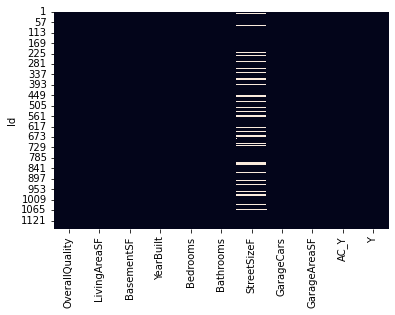

In [81]:
sns.heatmap(df_train.isna(), cbar=False)
plt.show()

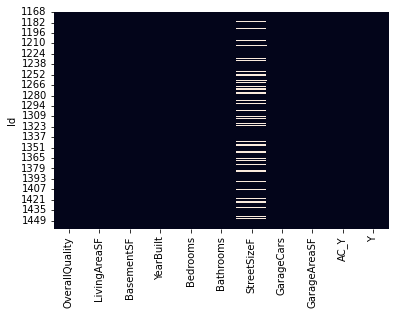

In [82]:
sns.heatmap(df_test.isna(), cbar=False)
plt.show()

In [83]:
df_train.isna().sum()

OverallQuality      0
LivingAreaSF        0
BasementSF          0
YearBuilt           0
Bedrooms            0
Bathrooms           0
StreetSizeF       206
GarageCars          0
GarageAreaSF        0
AC_Y                0
Y                   0
dtype: int64

In [84]:
# in percentages
df_train.isna().sum()/len(df_train)

OverallQuality    0.000000
LivingAreaSF      0.000000
BasementSF        0.000000
YearBuilt         0.000000
Bedrooms          0.000000
Bathrooms         0.000000
StreetSizeF       0.176521
GarageCars        0.000000
GarageAreaSF      0.000000
AC_Y              0.000000
Y                 0.000000
dtype: float64

In [85]:
df_test.isna().sum()

OverallQuality     0
LivingAreaSF       0
BasementSF         0
YearBuilt          0
Bedrooms           0
Bathrooms          0
StreetSizeF       53
GarageCars         0
GarageAreaSF       0
AC_Y               0
Y                  0
dtype: int64

Let us verify whether this data is actually missing or whether its absence is significant.

E.g. in our case it might indicate that no street is connected to the property.

In order to verify this, let us plot the distribution of the existing values and the distribution of the NaN values against the target. We can do this on the original dataframe (before the split).

Assuming that the price of houses without a connecting street would be lower than the price of houses with a connecting street, if we were to observe different distributions, we shall conclude that the "missing" values are not actually "missing", but that they rather indicate the absence of a connecting street. On the contrary, if both distributions appear to be the same, we can then conclude that the "missing" data are non-significant and indeed just missing.

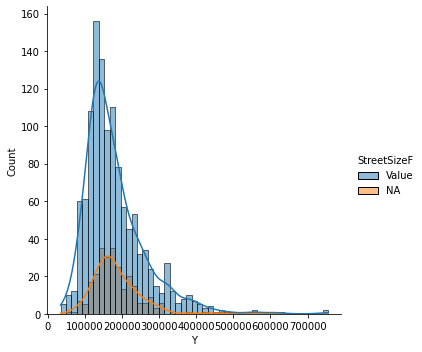

In [86]:
# let's make a separate df with our col and the target
tmp = df[['StreetSizeF', 'Y']]

# let's change the values of our col as follows:
# any value --> "Value" (str)
# NaN --> "NA" (str)
tmp['StreetSizeF'] = tmp['StreetSizeF'].apply(lambda x:
                                              "Value" if not pd.isna(x)
                                              else "NA")

# Let's plot the distribution of the two categories 
# "Value" and "NA" against the target
sns.displot(data=tmp, x='Y', hue='StreetSizeF', kde=True)
plt.show()

The distributions look very similar. We conclude that the missing values are not significant.

Let us impute the missing values with the mean of the column.

N.B. Note that we should use the mean of the train set only (if we have not yet split our dataset and our intention is to carry out an 80% vs 20% train-test split, we should use the mean calculated upon 80% of the dataset).

In [87]:
# mean of 80% of the dataset

# if we were to do this before splitting
# col_mean = df['StreetSizeF'].head( int(0.8*len(df)) ).mean()
# print(col_mean)

# if we were do this after splitting
col_mean = df_train['StreetSizeF'].mean()
print(col_mean)

69.95941727367325


In [88]:
# impute train set
df_train['StreetSizeF'] = df_train['StreetSizeF'].fillna(col_mean)

# impute test set
df_test['StreetSizeF'] = df_test['StreetSizeF'].fillna(col_mean)

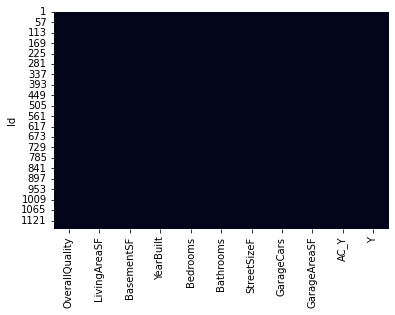

In [89]:
sns.heatmap(df_train.isna(), cbar=False)
plt.show()

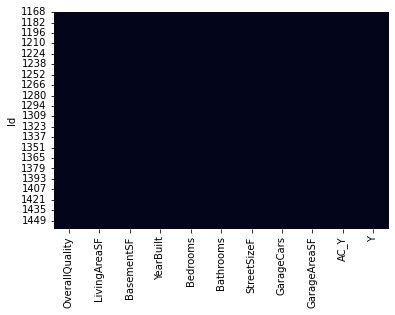

In [90]:
sns.heatmap(df_test.isna(), cbar=False)
plt.show()

In [91]:
df_train['StreetSizeF'].isna().sum()

0

In [92]:
df_test['StreetSizeF'].isna().sum()

0

<a name="s06c"></a>
### c) Resampling

Not needed for a regression task

<a name="s06d"></a>
### d) Scaling

Since we have a lot of outliers, let us use the RobustScaler which employs the 25th and 7th percentile, avoiding outlier effects on the scaling process.

In [93]:
# scale df_train 
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
scalerX.fit(df_train.drop('Y', axis=1))
X = scalerX.transform(df_train.drop('Y', axis=1))
df_train_scaled = pd.DataFrame(X, columns=df_train.drop('Y', axis=1).columns, index=df_train.index)

# if you want to scale the Y too
# scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
# df_train_scaled['Y'] = scalerY.fit_transform(df_train['Y'].values.reshape(-1,1))
# otherwise
df_train_scaled['Y'] = df_train['Y']

# scale df_test
X = scalerX.transform(df_test.drop('Y', axis=1))
df_test_scaled = pd.DataFrame(X, columns=df_test.drop('Y', axis=1).columns, index=df_test.index)

# if you want to scale the Y too
# df_test_scaled['Y'] = scalerY.fit_transform(df_test['Y'].values.reshape(-1,1))
# otherwise
df_test_scaled['Y'] = df_test['Y']

In [94]:
df_train.head()

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,StreetSizeF,GarageCars,GarageAreaSF,AC_Y,Y
Id,,,,,,,,,,,
1,7,1710,856,2003,3,2,65.0,2,548,1,208500
2,6,1262,1262,1976,3,2,80.0,2,460,1,181500
3,7,1786,920,2001,3,2,68.0,2,608,1,223500
4,7,1717,756,1915,3,1,60.0,3,642,1,140000
5,8,2198,1145,2000,4,2,84.0,3,836,1,250000


In [95]:
df_train_scaled.head()

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,StreetSizeF,GarageCars,GarageAreaSF,AC_Y,Y
Id,,,,,,,,,,,
1,0.5,0.395639,-0.291378,0.652174,0.0,0.0,-0.261022,0.0,0.288066,0.0,208500
2,0.0,-0.302181,0.513380,0.065217,0.0,0.0,0.528452,0.0,-0.074074,0.0,181500
3,0.5,0.514019,-0.164519,0.608696,0.0,0.0,-0.103127,0.0,0.534979,0.0,223500
4,0.5,0.406542,-0.489594,-1.260870,0.0,-1.0,-0.524180,1.0,0.674897,0.0,140000
5,1.0,1.155763,0.281467,0.586957,1.0,0.0,0.738978,1.0,1.473251,0.0,250000


In [96]:
df_test.head()

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,StreetSizeF,GarageCars,GarageAreaSF,AC_Y,Y
Id,,,,,,,,,,,
1168,6,1671,959,2000,3,2,58.0,2,472,1,173000
1169,6,2108,1127,1935,4,2,120.0,2,540,1,235000
1170,10,3627,1930,1995,4,3,118.0,3,807,1,625000
1171,6,1118,1096,1977,3,1,76.0,1,358,1,171000
1172,6,1261,1261,1958,3,1,76.0,2,433,1,163000


In [97]:
df_test_scaled.head()

,OverallQuality,LivingAreaSF,BasementSF,YearBuilt,Bedrooms,Bathrooms,StreetSizeF,GarageCars,GarageAreaSF,AC_Y,Y
Id,,,,,,,,,,,
1168,0.0,0.334891,-0.087215,0.586957,0.0,0.0,-0.629443,0.0,-0.024691,0.0,173000
1169,0.0,1.015576,0.245788,-0.826087,1.0,0.0,2.633715,0.0,0.255144,0.0,235000
1170,2.0,3.381620,1.837463,0.478261,1.0,1.0,2.528452,1.0,1.353909,0.0,625000
1171,0.0,-0.526480,0.184341,0.086957,0.0,-1.0,0.317925,-1.0,-0.493827,0.0,171000
1172,0.0,-0.303738,0.511397,-0.326087,0.0,-1.0,0.317925,0.0,-0.185185,0.0,163000


<a name="s06e"></a>
### e) Identifying Redundant Features (Multicollinearity)

Text(0.5, 1.0, 'Pearson Correlation Matrix Heatmap')

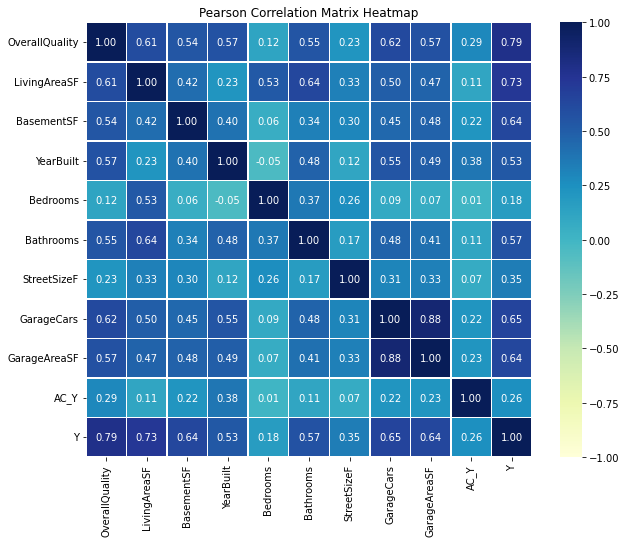

In [98]:
corr_matrix = df_train_scaled.corr(method='pearson')
plt.figure(figsize=(10,8))
ax = sns.heatmap(corr_matrix, 
            vmin=-1.,
            vmax=1.,
            annot=True,
            fmt='.2f',
            cmap="YlGnBu",
            cbar=True,
            linewidths=0.5)
plt.title('Pearson Correlation Matrix Heatmap')

We can observe that 'GarageCars' and 'GarageAreaSF' are highly correlated (0.88). This is reasonable as both variables describe the size of the garage.

We might want to drop one of the two. It appears that 'GarageCars' might be slightly more predictive of our target variable than 'GarageSizeSF' (0.65 vs 0.64). Let us run some tests below, as we carry out our final feature selection, and decide which of the two variables to drop.

<a name="s06f"></a>
### f) Feature Selection

We have already carried out a first stage of Feature Selection by identifying the predictive features.

Let us now go one step further and use an Ensemble method to predict feature importance and further select our features on the basis of the results.

In [99]:
# from sklearn import ensemble

# prepare input X feature matrix and Y label vector
X = df_train_scaled.drop('Y', axis=1).values
y = df_train_scaled['Y'].values

# fit the Ensemble model
model = ensemble.GradientBoostingRegressor()
model.fit(X, y)

GradientBoostingRegressor()

In [100]:
# extract the importances from the model and store them in a df
importances = model.feature_importances_ # np.array

feature_cols = df_train_scaled.drop('Y', axis=1).columns.to_list()

df_importance = pd.DataFrame({'Importance':importances,
                              'Variable':feature_cols}
                             ).sort_values('Importance', ascending=False)

df_importance['Cumulative'] = df_importance['Importance'].cumsum(axis=0)

df_importance = df_importance.set_index('Variable')

df_importance

,Importance,Cumulative
Variable,,
OverallQuality,0.555820,0.555820
LivingAreaSF,0.209399,0.765220
BasementSF,0.085549,0.850768
YearBuilt,0.048137,0.898905
GarageCars,0.045024,0.943929
StreetSizeF,0.017662,0.961590
GarageAreaSF,0.017180,0.978771
Bathrooms,0.008959,0.987730
Bedrooms,0.007950,0.995680


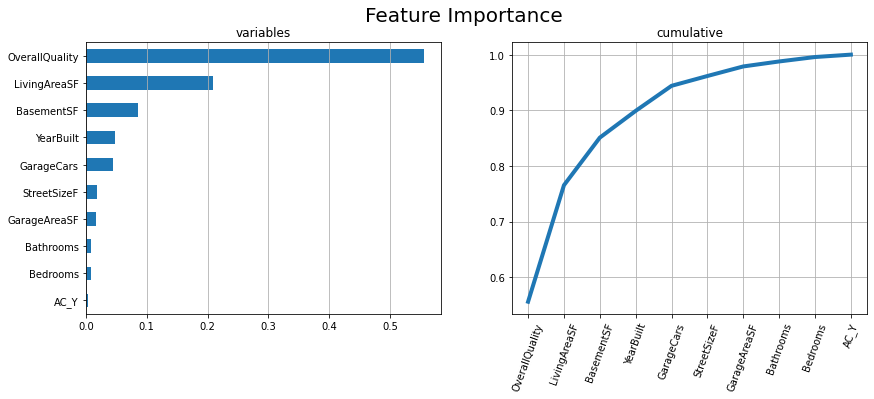

In [101]:
## Plot Feature Importance Dataframe
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharex=False, sharey=False)
fig.suptitle("Feature Importance", fontsize=20)
ax[0].title.set_text('variables')
df_importance[["Importance"]].sort_values(by="Importance").plot(
          kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
df_importance[["Cumulative"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importance)), 
          xticklabels=df_importance.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

We can observe that 'GarageCars' is more important than 'GarageAreaSF', so we can drop the latter.

We can also observe that 'OverallQuality', 'LivingAreaSF', 'BasementSF', 'GarageCars' and 'YearBuilt' are significantly more predictive than the remaining ones and altogether make up over 90% of the cumulative importance. 

So, if our goal is to use as fewer features as possible in our ML model, we might decide to keep only these five.

In [102]:
selected_features = ['OverallQuality', 'LivingAreaSF', 'BasementSF', 'GarageCars', 'YearBuilt']

In [103]:
df_train_final = pd.concat([df_train_scaled[selected_features], df_train_scaled['Y']], axis=1) 
df_train_final.head()

,OverallQuality,LivingAreaSF,BasementSF,GarageCars,YearBuilt,Y
Id,,,,,,
1,0.5,0.395639,-0.291378,0.0,0.652174,208500
2,0.0,-0.302181,0.513380,0.0,0.065217,181500
3,0.5,0.514019,-0.164519,0.0,0.608696,223500
4,0.5,0.406542,-0.489594,1.0,-1.260870,140000
5,1.0,1.155763,0.281467,1.0,0.586957,250000


In [104]:
df_test_final = pd.concat([df_test_scaled[selected_features], df_test_scaled['Y']], axis=1) 
df_test_final.head()

,OverallQuality,LivingAreaSF,BasementSF,GarageCars,YearBuilt,Y
Id,,,,,,
1168,0.0,0.334891,-0.087215,0.0,0.586957,173000
1169,0.0,1.015576,0.245788,0.0,-0.826087,235000
1170,2.0,3.381620,1.837463,1.0,0.478261,625000
1171,0.0,-0.526480,0.184341,-1.0,0.086957,171000
1172,0.0,-0.303738,0.511397,0.0,-0.326087,163000


<a name="s07"></a>
## 7) Model Design

a) [Create Input Matrices](#s07a)

b) [Baseline Model: Linear Regression](#s07b)

c) [XGBoost](#s07c)

d) [Neural Network](#s07d)

<a name="s07a"></a>
### a) Create Input Matrices

In [105]:
# our input X feature matrix and Y label vector must be arrays not dfs

X_train = df_train_final[selected_features].values
y_train = df_train_final["Y"].values
X_test = df_test_final[selected_features].values
y_test = df_test_final["Y"].values

In [106]:
X_train.shape

(1167, 5)

In [107]:
type(X_train)

numpy.ndarray

In [108]:
X_test.shape

(292, 5)

In [109]:
y_train.shape

(1167,)

In [110]:
y_test.shape

(292,)

<a name="s07b"></a>
### b) Baseline Model: Linear Regression

In [111]:
# from sklearn import linear_model

model = linear_model.LinearRegression()

# fit on the train set X and y
model.fit(X_train, y_train)

# predict on the test set X
predicted = model.predict(X_test)

# in case we had scaled the y:
# predicted = scalerY.inverse_transform(predicted.reshape(-1,1)).reshape(-1)

Let's use PCA to reduce the dimensionality and create a simple visualization by plotting the regression plane.

In [112]:
# from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
X2D = pca.fit_transform(X_train)

model2D = linear_model.LinearRegression()
model2D.fit(X2D, y_train)

LinearRegression()

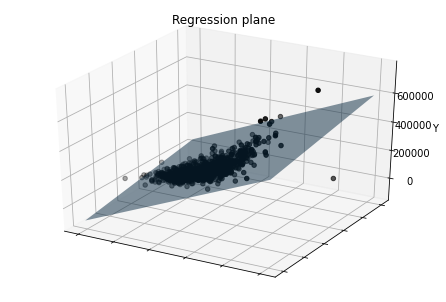

In [113]:
# from mpl_toolkits.mplot3d import Axes3D

ax = Axes3D(plt.figure())
ax.scatter(X2D[:,0], X2D[:,1], y_train, color='black')
x1 = np.array([[X2D.min(), X2D.min()], [X2D.max(), X2D.max()]])
x2 = np.array([[X2D.min(), X2D.max()], [X2D.min(), X2D.max()]])
y = model2D.predict(np.array([
    [X2D.min(), X2D.min(), X2D.max(), X2D.max()],
    [X2D.min(), X2D.max(), X2D.min(), X2D.max()]]).T
    ).reshape((2,2))
ax.plot_surface(x1, x2, y, alpha=0.5)
ax.set(zlabel="Y", title="Regression plane", xticklabels=[], yticklabels=[])
plt.show()

Let's evaluate the baseline model with the R-squared (R2) metric, the proportion of the variance in the dependent variable that is predictable from the independent variable.

In [114]:
# from sklearn import metrics

metrics.r2_score(y_test, predicted)

0.8022057161338333

Our baseline model, a simple linear regression model, scored an r-squared score of 0.80 or 80%.

<a name="s07c"></a>
### c) XGBoost

Let us try a more advanced machine learning model

In [115]:
# from sklearn import ensemble

model = ensemble.GradientBoostingRegressor()

# fit on the train set X and y
model.fit(X_train, y_train)

# predict on the test set X
predicted = model.predict(X_test)

# in case we had scaled the y:
# predicted = scalerY.inverse_transform(predicted.reshape(-1,1)).reshape(-1)

In [116]:
y_test.shape

(292,)

In [117]:
predicted.shape

(292,)

Let's use PCA to reduce dimensionality for easy visualization by plotting the regression plane.

In [118]:
# from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
X2D = pca.fit_transform(X_train)

model2D = ensemble.GradientBoostingRegressor()
model2D.fit(X2D, y_train)

GradientBoostingRegressor()

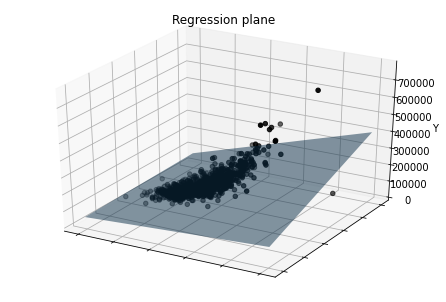

In [119]:
# from mpl_toolkits.mplot3d import Axes3D

ax = Axes3D(plt.figure())
ax.scatter(X2D[:,0], X2D[:,1], y_train, color='black')
x1 = np.array([[X2D.min(), X2D.min()], [X2D.max(), X2D.max()]])
x2 = np.array([[X2D.min(), X2D.max()], [X2D.min(), X2D.max()]])
y = model2D.predict(np.array([
    [X2D.min(), X2D.min(), X2D.max(), X2D.max()],
    [X2D.min(), X2D.max(), X2D.min(), X2D.max()]]).T
    ).reshape((2,2))
ax.plot_surface(x1, x2, y, alpha=0.5)
ax.set(zlabel="Y", title="Regression plane", xticklabels=[], yticklabels=[])
plt.show()

Let's run the metrics

In [120]:
# from sklearn import metrics

metrics.r2_score(y_test, predicted)

0.8777964596562998

R2 (explained variance): 0.88
MAPE - Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.11
MAE - Mean Absolute Error (Σ|y-pred|/n): 19,727
RMSE - Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 28,623
Max Error: -148,868


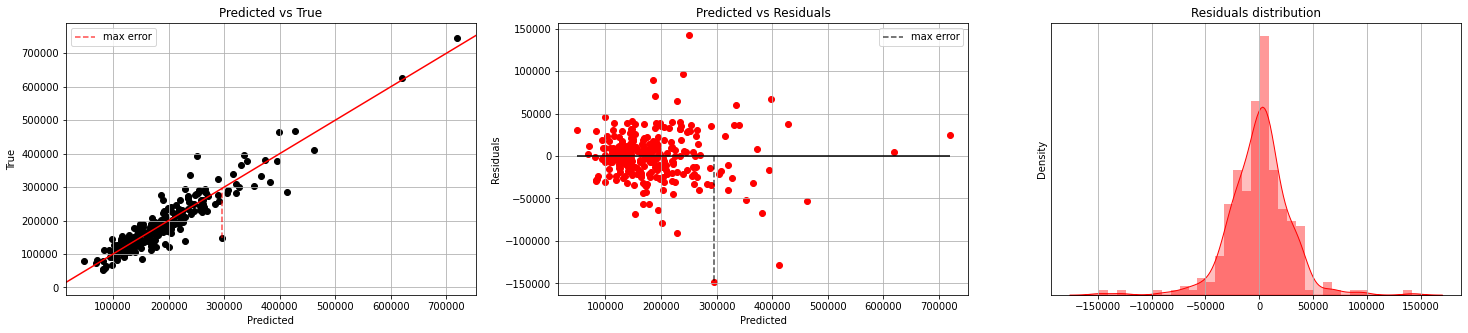

In [121]:
evaluate_regr_model(y_test, predicted, figsize=(25,5))

Our performance has improved from the 80% of the baseline Linear Regression to an 88% with the XGBoost.

The model predictions are wrong by 11% (see MAPE).

The average prediction error (see MAE) is around 19-20k.

The bigges error we made on the test set was wrong by around 148k.

The model is not perfect, but might be good enough depending on the goal. Let's see if our performance improves if we train a neural network.

<a name="s07d"></a>
## d) Neural Network

In [122]:
# from tensorflow.keras import models, layers, backend

In [123]:
# custom metric: R-squared
def R2(y, y_hat):
    ss_res = backend.sum(backend.square(y - y_hat)) 
    ss_tot = backend.sum(backend.square(y - backend.mean(y))) 
    return ( 1 - ss_res/(ss_tot + backend.epsilon()) )

In [124]:
n_features = len(selected_features) # or X_train.shape[1] # in our case 5

model = models.Sequential(name="Deep_NN", layers=[
    # layer input
    layers.Input(name="input", shape=(n_features,)),
    # hidden layer 1
    layers.Dense(name="h1", units=512, activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    # hidden layer 2
    layers.Dense(name="h2", units=256, activation='relu'),
    layers.Dropout(name="drop2", rate=0.2),
    # hidden layer 3
    layers.Dense(name="h3", units=128, activation='relu'),
    layers.Dropout(name="drop3", rate=0.2),
    # layer output
    layers.Dense(name="output", units=1, activation='linear')
])

# MAE is the default loss function for regression tasks
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[R2])

model.summary()

Model: "Deep_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 512)               3072      
                                                                 
 drop1 (Dropout)             (None, 512)               0         
                                                                 
 h2 (Dense)                  (None, 256)               131328    
                                                                 
 drop2 (Dropout)             (None, 256)               0         
                                                                 
 h3 (Dense)                  (None, 128)               32896     
                                                                 
 drop3 (Dropout)             (None, 128)               0         
                                                                 
 output (Dense)              (None, 1)                 129 

In [125]:
training = model.fit(X_train, y_train, 
                     batch_size=32, 
                     epochs=100, 
                     shuffle=True, 
                     verbose=1, # 'auto', 0 = silent, 1 = progress bar, 2 = single line
                     validation_split=0.3)

Epoch 1/100
26/26 [==============================] - 3s 13ms/step - loss: 183915.5625 - R2: -5.8627 - val_loss: 172823.6875 - val_R2: -7.8891
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 183748.6875 - R2: -5.5200 - val_loss: 172401.1562 - val_R2: -7.8501
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 182608.3281 - R2: -6.0468 - val_loss: 170140.4375 - val_R2: -7.6435
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 178031.1406 - R2: -5.6046 - val_loss: 162437.7656 - val_R2: -6.9656
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 164697.3906 - R2: -4.7109 - val_loss: 143008.0312 - val_R2: -5.3915
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 135940.9688 - R2: -3.0182 - val_loss: 107749.5625 - val_R2: -2.9336
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 97794.6250 - R2: -1.2883 - val_loss: 68970.1172 - val_R2: -0.7392
Epoch 8/100
26

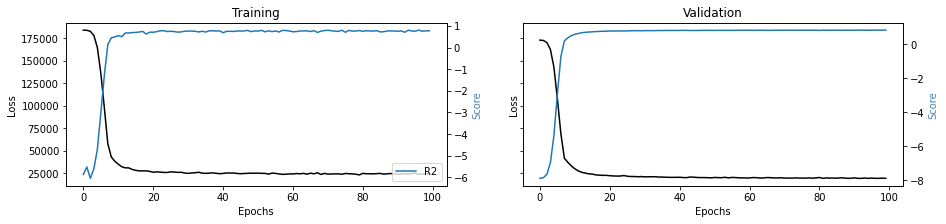

In [126]:
# let's plot our R2 score (in blue) against the loss (in black)
plot_keras_loss(training)

In [127]:
type(training)

keras.callbacks.History

In [128]:
# the fitted model is available at:
type(training.model)

keras.engine.sequential.Sequential

In [129]:
## test
predicted = training.model.predict(X_test)
# this gives a (292, 1) shape, but we need a (292, ) shape
predicted = predicted.reshape(-1)

# in case we had scaled the Y:
# predicted = scalerY.inverse_transform(predicted)

10/10 [==============================] - 0s 3ms/step


R2 (explained variance): 0.86
MAPE - Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.11
MAE - Mean Absolute Error (Σ|y-pred|/n): 20,641
RMSE - Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 30,692
Max Error: 158,570


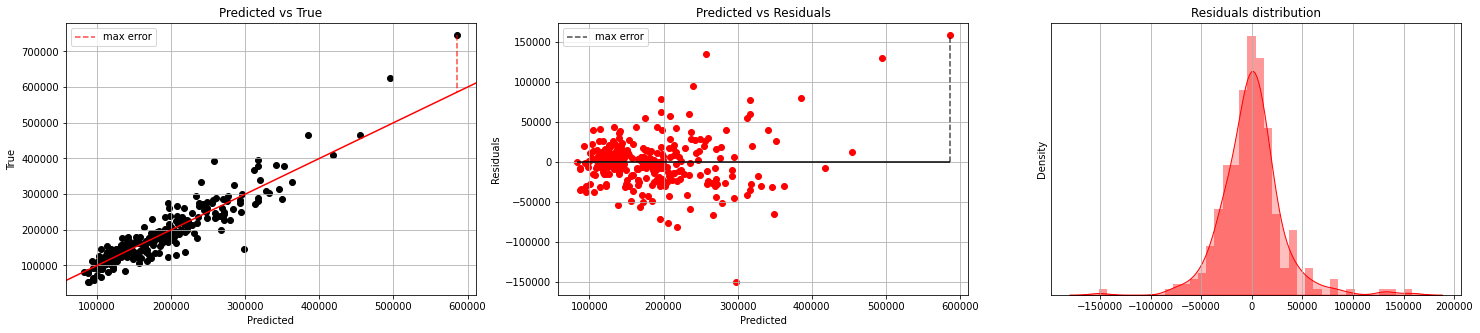

In [130]:
evaluate_regr_model(y_test, predicted, figsize=(25,5))

Our neural network performance is comparable to that of the XGBoost (if not slightly worse) with an 86% vs an 88% R-squared score.

The NN model predictions are wrong by 11% (see MAPE).

The average prediction error (see MAE) is around 20k.

The bigges error we made on the test set was wrong by around 158k (vs 148k of the XGBoost model).

<a name="s08"></a>
## 8) Explainability

Let us explain how each variables contributed to our predictions.

Let us take a random example, e.g. the first one in the test set

In [131]:
y_test[0]

173000

In [132]:
predicted[0]

187334.77

In [133]:
y_test[0] - predicted[0]

-14334.765625

The property we're investigating was priced 173,000 and our model predicted 187,334, missing by around 14k.

Let us find out why our model predicted a higher price by using Lime.

In [134]:
# from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
            training_data=X_train,
            feature_names=selected_features,
            class_names='Y',
            mode='regression')

157/157 [==============================] - 1s 3ms/step


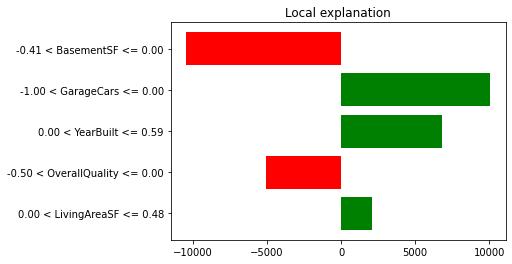

In [135]:
explained = explainer.explain_instance(X_test[0],
                                      training.model.predict,
                                      num_features=5)

explained.as_pyplot_figure()
plt.show()

Here we can see which variables contributed to our model prediction.

We can also investigate how each variable contributed to our biggest error.

In [136]:
error = y_test - predicted

In [137]:
error.shape

(292,)

In [138]:
max_error = max(abs(error))
max_error

158570.1875

In [139]:
# let us find the index of our biggest error

for i in range(len(predicted)):
  # if y_test[i] - predicted[i] == -707981.0625
  if abs(error[i]) == max_error:
    print(i)

15


In [140]:
df_test.iloc[15]

OverallQuality        10.0
LivingAreaSF        4476.0
BasementSF          2396.0
YearBuilt           1996.0
Bedrooms               4.0
Bathrooms              3.0
StreetSizeF          160.0
GarageCars             3.0
GarageAreaSF         813.0
AC_Y                   1.0
Y                 745000.0
Name: 1183, dtype: float64

In [141]:
y_test[15]

745000

In [142]:
predicted[15]

586429.8

In [143]:
y_test[15] - predicted[15]

158570.1875

This property was priced 745,000 but our model predicted a much lower price, 586,429, missing by 158,570.

Let us visualize the contribution of each variable.

In [144]:
explained = explainer.explain_instance(X_test[15],
                                      training.model.predict,
                                      num_features=5)

157/157 [==============================] - 0s 2ms/step


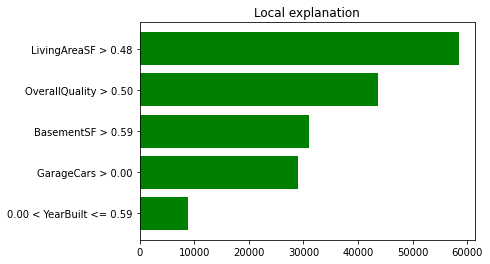

In [145]:
explained.as_pyplot_figure()
plt.show()